# CAPSTONE PROJECT: PREDICTING BICYCLE RENTALS
# DTSC 691: DEFAULT MACHINE LEARNING PROJECT
## NAME: STEPHEN O'DEA

The goal of this project is to build a supervised regression model to predict the number of individuals that will rent a bike at any given time, on any given day. This dataset was made publicly available by the company Capital-Bikeshare in Washington D.C. Since making the data public, Fanaee-T, Hadi, and Joao Gama have added weather and seasonal information to the dataset.

The main focus of model construction will not be soley based on predictive performance. Rather, we aim to build practical models, ones that are robust and provide stable predictions for a potential client/boss. If a less complex model performs similarly on unseen data then that model will be chosen since less complex models exhibit higher levels of interpretability. This increase in interpretability makes it easier to explain the effects of the attributes on the number of bike rentals. If this is not the case, any evidence from exploratory data analysis will be the main-driver in explaining these relationships.

In addition to training a model and creating a user-interface, there are a number of research questions that need to be considered, such as:

 - How do different weather-related variables impact the number of bicycles rented? Weather-related variables may include predictors such as temperature, humidity, and season.
 - Does there exist seasonality in the number of bicycle rentals? i.e., do we expect more bikes to be rented in the spring vs the fall?
 - Does time of day or day of week correlate with total rentals?

# 0. PREREQUISITES

## 0.1 DATA DESCRIPTION
There are two datasets available: hour.csv and  day.csv. Both of these datasets contain the same information except that one is aggregated by hour and one is aggregated by day. The hour dataset is used since it contains more observations.

The following is a description of all of the variables. This information was taken directly from the UCI Machine Learning Repository. Both hour.csv and day.csv have the following fields except `hr` which is not available in day.csv.

  - `instant`: record index
  - `dteday` : date
  - `season` : season
    - 1: winter
    - 2: spring
    - 3: summer
    - 4: fall
  - `yr` : year
    - 0: 2011
    - 1: 2012
  - `mnth` : month ( 1 to 12)
  - `hr` : hour (0 to 23)
  - `holiday` : weather day is holiday or not
    - 0: not holiday
    - 1: holiday
  - `weekday` : day of the week
  - `workingday` : day is neither weekend nor holiday
    - 0: not a working day
    - 1: working day
  - `weathersit` :
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
  - `temp` : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
  - `atemp`: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
  - `hum`: Normalized humidity. The values are divided to 100 (max)
  - `windspeed`: Normalized wind speed. The values are divided to 67 (max)
  - `casual`: count of casual users
  - `registered`: count of registered users
  - `cnt`: count of total rental bikes including both casual and registered

## 0.2 IMPORT LIBRARIES

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Model Validation
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text
from statsmodels import graphics

# Linear Regression / GLM
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Tree Based Methods
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Graphical displays
import seaborn as sns
sns.set(style='ticks',
        context='paper')  # Set Theme for Seaborn Plots

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# To plot pretty tables
from prettytable import PrettyTable

# File Structures
import os

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR,
                           "Figures")

DATA_PATH = os.path.join(PROJECT_ROOT_DIR,
                         'Data')

os.makedirs(DATA_PATH, exist_ok = True)
os.makedirs(IMAGES_PATH, exist_ok = True)

## 0.3 FUNCTIONS

In [2]:
#### FUNCTIONS
# Import Data from GitHub
def import_data():
    # Get URL of Data
    url = 'https://raw.githubusercontent.com/StephenODea54/Bike_Sharing_Dataset_ML_Project/main/Data/hour.csv'
    
    # Download to DataFrame
    df = pd.read_csv(url)
    
    # Return df
    return df
    
# Where to Save Figures
def save_fig(fig_id, tight_layout = True, fig_extension = "jpg", resolution = 300):
    # Define Path
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    
    # Force tight_layout for figures
    if tight_layout:
        plt.tight_layout()
        
    # Save Figure
    plt.savefig(path, format = fig_extension, dpi = resolution)

# Calculate RMSE
def calculate_rmse(model, features, target):
    #Calculate RMSE
    rmse = mean_squared_error(target, model.predict(features), squared = False)
    
    # Print to Screen
    print('The RMSE of the model is: {:.2f}'.format(rmse))
    
    # Return RMSE
    return rmse

def calculate_rmse_cv(model, feature, target):
    # Calculate MSE
    scores = cross_val_score(model, feature, target,
                            scoring = 'neg_mean_squared_error', cv = 5)
    
    # Calculate Average of RMSE Score
    rmse_scores = np.sqrt(-scores)
    mean_rmse = np.mean(rmse_scores)
    
    print('The average RMSE score is : {:.2f}'.format(mean_rmse))
    
    return mean_rmse   

# Calculate RMSE on the Test Set
# This is identical to calculate_rmse() but does not print anything to screen since values are displayed in PrettyTable()
def calculate_rmse_test(model):
    #Calculate RMSE
    rmse = mean_squared_error(y_test, model.predict(X_test), squared = False)
    
    # Return RMSE
    return rmse

# Calculate Nodes from Decision Tree
def calculate_nodes(mod):
    # Extract Node Count
    num_nodes = mod.tree_.node_count
    
    # Print to Screen
    print(f'There are {num_nodes} nodes in the regression tree.')

# Calculate Feature Importance
def calculate_feature_imp(mod, features, title, save_title):
    # Create DataFrame for Features
    feature_importances = pd.DataFrame({
        'features': features.columns,
        'importance': mod.feature_importances_
    })

    # Sort by Importance
    feature_importances.sort_values(by = ['importance'], ascending = False, inplace = True)

    # Set Figure Size and Title
    plt.figure(figsize = (20, 15))
    plt.suptitle(title, fontsize = 16)
    
    # Plot
    sns.barplot(x = 'features', y = 'importance', data = feature_importances)

    # Save
    save_fig(save_title)

# 1. DATA PREPARATION

Import data and view first 10 instances.

In [3]:
# Import Data
df = import_data()

# View First 10 Rows
df.head(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


The target variable is `cnt`. Note that all of the attributes besides `dteday` are integer-valued. Before considering the nature of the variables, it is necessary to look at their types. While doing so, dimensionality and missing values will also be considered.

In [4]:
# Look at variable types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


There are no missing values and there exists 17,739 instances and 17 total variables for a dimensionality of 301,563 which is a decent amount for a machine learning project. Now it must be determined if each of the variable types are appropriate for each attribute. Often times the choice of numeric vs categorical ultimately depends on the nature of the machine learning project, meaning that there are usually justifications for using either. For this analysis, the following discrete variables will be recoded as an object:

 - `season`
 - `hr`
 - `mnth`
 - `holiday`
 - `weekday`
 - `workingday`
 - `weathersit`

The main justification is that most of these exhibit only a few distinct values, there is no natural numerical ordering between them, or they are binary. Two exceptions are `mnth` and `hr` which are comprised of 12 and 24 levels respectively, with `hr` having a potential numerical ordering. The main issue with high-dimensional categorical attributes is that depending on the machine learning algorithm they may increase the complexity of the model too much and result in overfitting. The reason for transforming `mnth` and `hr` is due to their cyclical nature.

Attributes not listed above will remain as is.

In [5]:
# Change Attribute Types
df = df.astype({
    'season': 'object',
    'hr': 'object',
    'mnth': 'object',
    'holiday': 'object',
    'weekday': 'object',
    'workingday': 'object',
    'weathersit': 'object'
})

# Confirm Changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  object 
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  object 
 5   hr          17379 non-null  object 
 6   holiday     17379 non-null  object 
 7   weekday     17379 non-null  object 
 8   workingday  17379 non-null  object 
 9   weathersit  17379 non-null  object 
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(5), object(8)
memory usage: 2.3+ MB


Before the EDA, `instant`, `dteday`, `yr`, `casual`, and `registered` will be removed from analysis.

 - `instant`: Represents the index of the records. Incorporating this variable provides no useful information and only complicates analysis.
 
 - `dteday` and `yr`: The data is only applicable for the years 2011 and 2012 and with such a small sample space it does not make sense to include any time-series analysis since any seasonality or trends in the data may not be credible. Since no time-series analysis will be performed, including these features is redundant. It could be argued that `yr` could potentially be recoded as an object, but this means that any predictive model would be constrained to predicting bicycle rentals in only these 2 years.
 
 - `casual` and `registered`: These variables represent the number of casual and registered users that have rented bikes. There are two problems when considering these variables:
 
    1. `cnt` is the combination of `casual` and `registered`. Including these two would lead to very misleading results.
    2. Even if these features were allowed to be incorporated it would not be possible to know the number of registered and non-registered users beforehand.

In [6]:
# Drop Variables
df = df.drop(columns = ['instant', 'dteday', 'yr', 'casual', 'registered'])

# 2. DATA PREPARATION AND EDA
Data preparation and EDA are indespensible to a machine learning project. The goal here is to get a "feel" for the data. Doing so gives a sense of the observations, helps identify potential errors or erroneous values, and helps portray the relationship between the attributes and the target.

## 2.1 UNIVARIATE DATA EXPLORATION
This section will be split into examining the numeric and categorical features separately.

### 2.1.1 NUMERIC VARIABLES

In [7]:
# Check Summary Statistics for the numeric variables
df.describe().applymap('{:.2f}'.format)

,temp,atemp,hum,windspeed,cnt
count,17379.00,17379.00,17379.00,17379.00,17379.00
mean,0.50,0.48,0.63,0.19,189.46
std,0.19,0.17,0.19,0.12,181.39
min,0.02,0.00,0.00,0.00,1.00
25%,0.34,0.33,0.48,0.10,40.00
50%,0.50,0.48,0.63,0.19,142.00
75%,0.66,0.62,0.78,0.25,281.00
max,1.00,1.00,1.00,0.85,977.00


`cnt` ranges from 1 to 977. The center of the distribution, based on the mean, is approximately 189. Contrast this with a median value of 142. Since the mean is significantly higher than the median, severe right-skewness is expected. Since `cnt` is greater than 0, a log-transformation is applicable here, but is not applied at this moment and will be applied during the model-fitting process where appropriate.

As expected, there are no indications of other skewed variables. This is expected the data dictionary states that these attributes are already normalized. We use histograms to better understand the nature of the distributions.

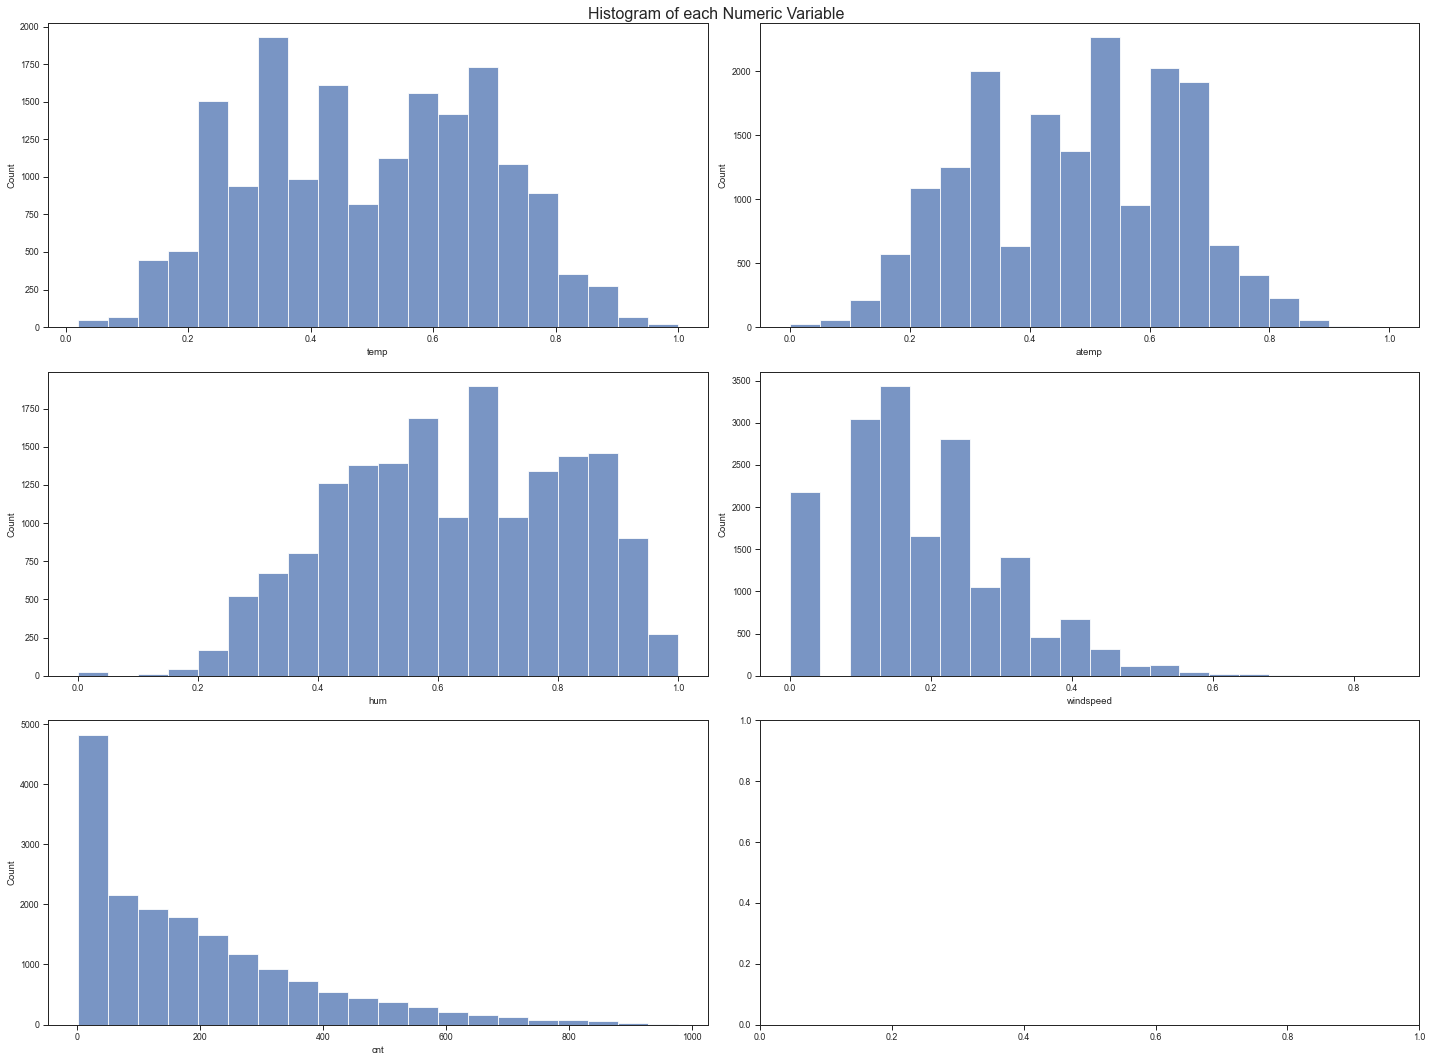

In [8]:
# Define Numerical Attributes
numerical_attrbs = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

# Define Figure and Title
fig, ax = plt.subplots(3, 2, figsize = (20, 15), sharey = False)
fig.suptitle('Histogram of each Numeric Variable',
             fontsize = 16)

# Plot Histograms
for attribute, subplot in zip(numerical_attrbs, ax.flatten()):
    sns.histplot(x = df[attribute],
                bins = 20,
                ax = subplot)

# Save Figure
save_fig('Histograms_Numeric_Attributes')

### 2.1.2 CATEGORICAL VARIABLES
To better understand the distribution of the categorical attributes, a frequency table is constructed to show the relative frequency within each level. The goal is to identify any incredibly sparse levels.

In [9]:
# Define Categorical Variables
categorical_attrbs = ['season', 'hr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

# Create Frequency Tables
for attribute in categorical_attrbs:
    counts = pd.DataFrame() # Using dataframe for nicer printing
    
    # Define Relative Frequency and Percentage
    counts['Relative Frequency'] = df[attribute].value_counts()
    counts['Relative Percentage'] = (counts['Relative Frequency'] / counts['Relative Frequency'].sum())
    counts['Relative Percentage'] = counts['Relative Percentage'].apply('{:.2%}'.format) # Round to 2 Decimal Places
    
    # Tring to make it even more pretty
    print('\033[1m' + attribute)
    print('\033[0m')
    print(counts.to_string(index = True))
    print('')

season

   Relative Frequency Relative Percentage
3                4496              25.87%
2                4409              25.37%
1                4242              24.41%
4                4232              24.35%

hr

    Relative Frequency Relative Percentage
17                 730               4.20%
16                 730               4.20%
13                 729               4.19%
15                 729               4.19%
14                 729               4.19%
12                 728               4.19%
22                 728               4.19%
21                 728               4.19%
20                 728               4.19%
19                 728               4.19%
18                 728               4.19%
23                 728               4.19%
11                 727               4.18%
10                 727               4.18%
9                  727               4.18%
8                  727               4.18%
7                  727               4.18%
0  

`season`, `hr`, `mnth` and `weekday` exhibit a similar number of observations within each level. The other variables, however, are predominately comprised of one level. This is to be expected for `holiday` and `workingday` since most days are not holidays and most days are work days. Also note that in `weathersit` there are only 3 observations for level 4. This level is removed from analysis since results from such a sparse level may be unreliable and may cause the model to try too hard to extract the signal from these observations when they may just be noise.

When the number of levels increases a frequency table becomes more and more difficult to read. Bar charts may better highlight the relative frequency of each level.

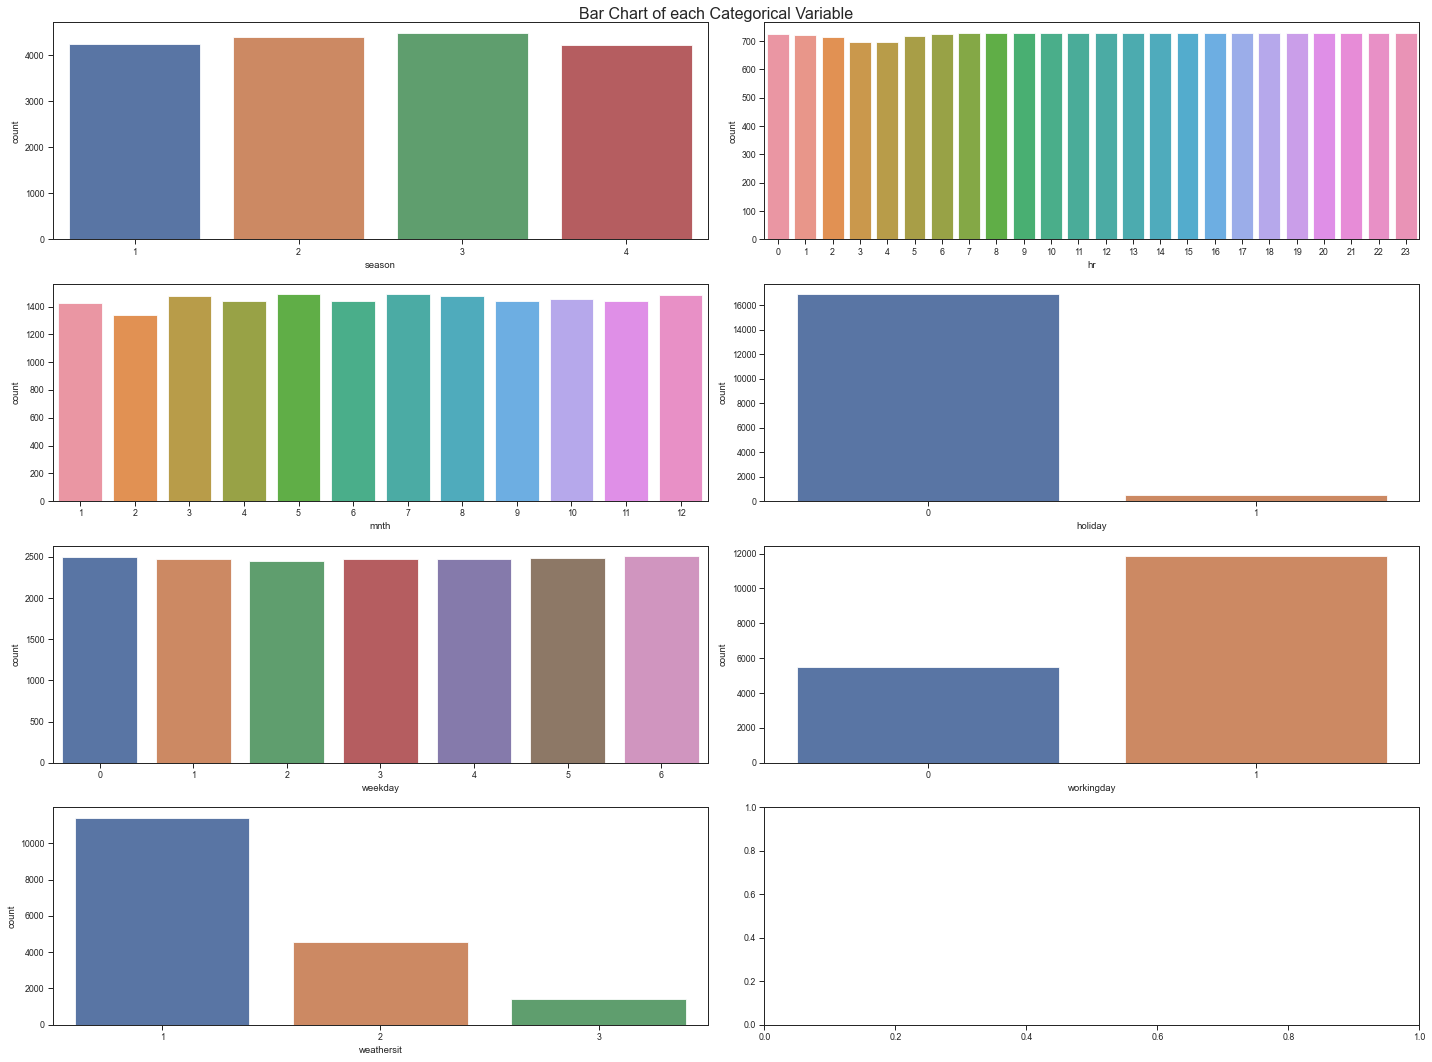

In [10]:
# Drop 4th level of weathersit
df = df[df['weathersit'] != 4]

# Define Figure and Title
fig, ax = plt.subplots(4, 2, figsize = (20, 15))
fig.suptitle('Bar Chart of each Categorical Variable',
             fontsize = 16)

# Plot Bar Charts
for attribute, subplot in zip(categorical_attrbs, ax.flatten()):
    sns.countplot(x = df[attribute], ax = subplot)

# Save Figure
save_fig('Bar_Charts_Categorical_Attributes')

## 2.2 BIVARIATE DATA EXPLORATION
We now consider the relationships between the predictors and the target variable. This section with also be split into examining the numeric and categorical attributes separately.

### 2.2.1 NUMERIC VARIABLES
Below is the correlation of the predictors and how they move in tandem with eachother.

In [11]:
# Compute Correlations
corr_matrix = df[numerical_attrbs].corr()

# Print Correlations to Screen
corr_matrix.applymap('{:.2f}'.format)

,temp,atemp,hum,windspeed,cnt
temp,1.00,0.99,-0.07,-0.02,0.40
atemp,0.99,1.00,-0.05,-0.06,0.40
hum,-0.07,-0.05,1.00,-0.29,-0.32
windspeed,-0.02,-0.06,-0.29,1.00,0.09
cnt,0.40,0.40,-0.32,0.09,1.00


`cnt` is moderatly positively correlated with `temp` and `atemp`. This means that as temperature increases the number of bicycle rentals normally increases as well. This result makes intuitive sense, as less people are expected to rent bikes when the weather is too cold. It is also worth mentioning than `cnt` is moderately negatively correlated with `hum`. This means that as the humidity increases the number of bicycle rentals normally decreases. This also makes sense since the number of bike users is expected to decrease once the weather becomes too humid or "sticky".

Examining the correlation between all other predictors indicates that some pairs of predictors are strongly correlated. `temp` and `atemp` have a correlation coefficient of nearly 99%. This extremely positive correlation could be a problem due to multicollinearity. Furthermore, both of these predictors practically explain the same thing in that one is the recorded normalized temperature and that the other is the normalized "feeling" temperature. Therefore, it would be best to drop one of these features due to redundancy as well as the multicollinearity concerns. `atemp` is removed since its interpretation is slighly more difficult to understand compared to `temp`.

All in all, it is likely that `temp` and `hum` are predictive of `cnt`.

To better extract any insights from the correlations above, a scatterplot matrix is constructed.

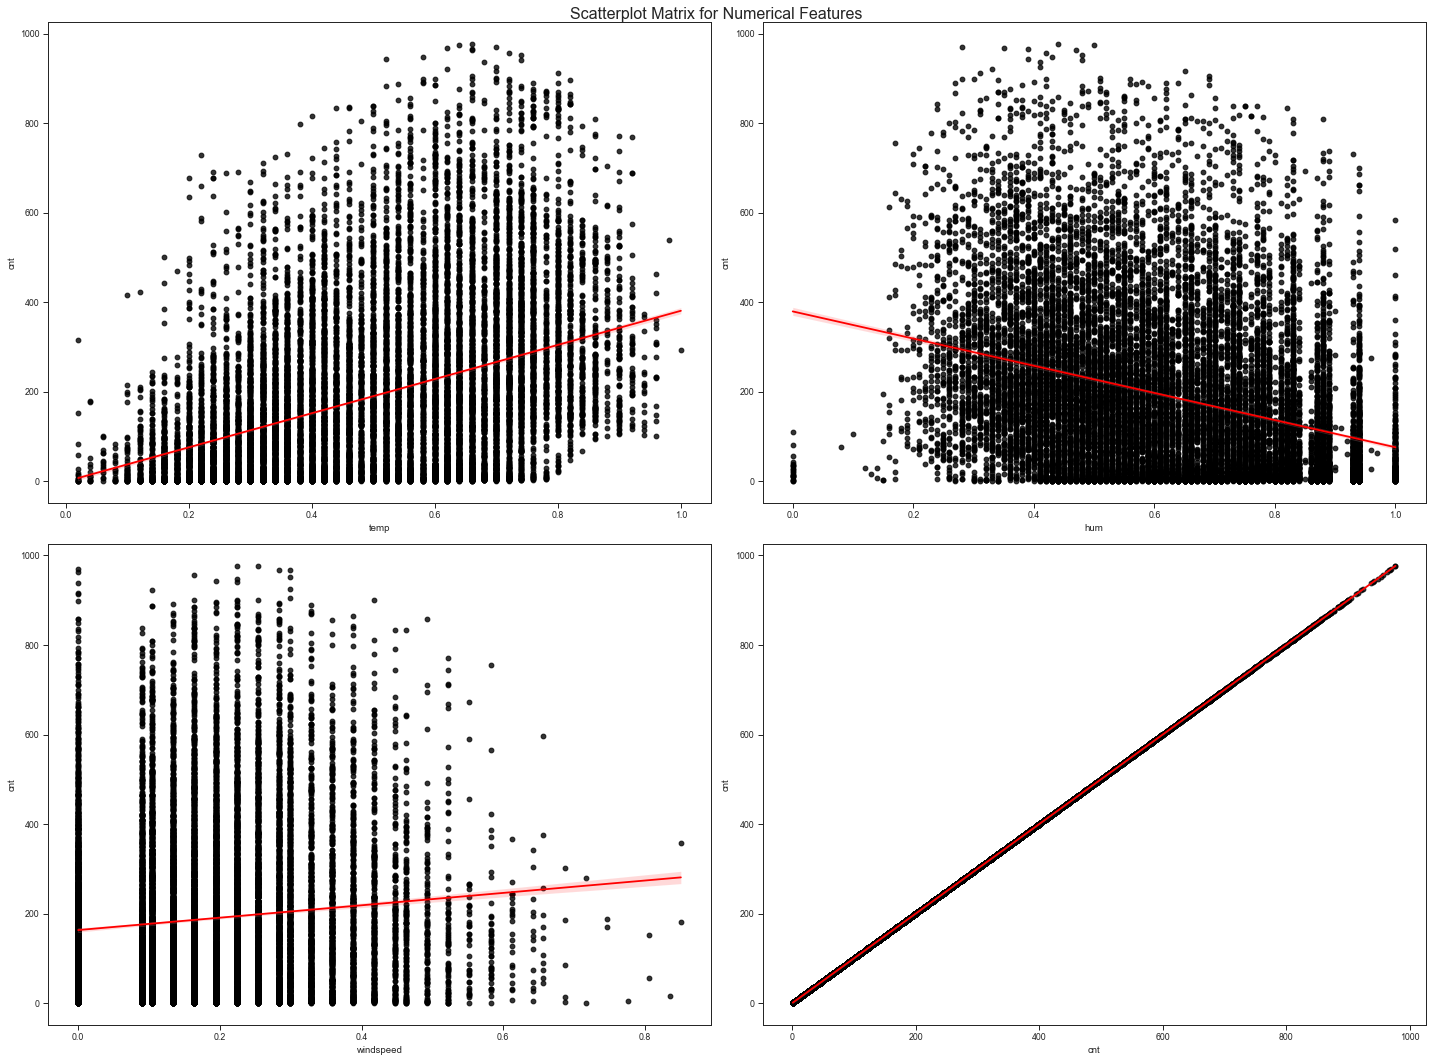

In [12]:
# Drop atemp
df = df.drop('atemp', axis = 1)

# Create list that excludes the target variable
numerical_attrbs = ['temp', 'hum', 'windspeed', 'cnt']

# Define Figure and Title
fig, ax = plt.subplots(2, 2, figsize = (20, 15))
fig.suptitle('Scatterplot Matrix for Numerical Features',
             fontsize = 16)

# Plot Scatterplots w/ Regression Line
for attribute, subplot in zip(numerical_attrbs, ax.flatten()):
    sns.regplot(x = df[attribute], y = df['cnt'], ax = subplot,
               scatter_kws = {"color": "black"}, line_kws = {"color": "red"})

# Save Figure
save_fig('Scatterplot_Matrix')

The scatterplots reveal that these relationships only appear to be mild since the fluction of the data points about the fitted line is substantial. This indicates that the attributes are likely not linearly related to the number of bicycle rentals.

### 2.2.2 CATEGORICAL VARIABLES
A similar strategy is adopted from above. Descriptive statistics and graphical displays are used to identify any meaningful differences within each level in relation to the target variable.

In [13]:
# Print the Mean, Median, and Count of each Object
for attribute in categorical_attrbs:
    print(df.groupby(attribute)['cnt'].agg(['mean', 'median', 'count']))
    print('') # Trying to make it easier to read

              mean  median  count
season                           
1       111.140599    76.0   4239
2       208.344069   165.0   4409
3       236.016237   199.0   4496
4       198.868856   155.5   4232

          mean  median  count
hr                           
0    53.898072    40.0    726
1    33.390041    20.0    723
2    22.869930    11.0    715
3    11.727403     6.0    697
4     6.352941     6.0    697
5    19.889819    19.0    717
6    76.044138    76.0    725
7   212.064649   208.0    727
8   359.011004   385.0    727
9   219.309491   216.0    727
10  173.668501   147.0    727
11  208.143054   180.0    727
12  253.315934   229.0    728
13  253.661180   224.0    729
14  240.949246   212.0    729
15  251.233196   227.0    729
16  312.362140   305.0    729
17  461.452055   475.0    730
18  425.870702   419.0    727
19  311.523352   309.5    728
20  226.030220   223.5    728
21  172.314560   173.5    728
22  131.335165   129.0    728
23   87.831044    80.0    728

            me

All variables seem to have a significant impact on the median of `cnt`, though the argument could be made that the number of bicycle rentals is more or less the same when aggregated by the different days of the week since they exhibit similar central tendencies. Note the levels 0 and 6 of this variable and how their median is lower than that of the other levels. 0 and 6 correspond to Sunday and Saturday respectively, so it can be concluded that bicycle rentals, on average, are consistently lower on the weekends. One strategy may be to collapse the levels into "weekend" and "weekday" to better illustrate this relationship. Doing that would result in an attribute nearly identical to that of `workingday`. Upon further inspection we actually find that `holiday` is the combination of `workingday` and `weekday`. Due to this, we drop `holiday` from the analysis. Note that we also could have dropped `workingday`, but recall that the levels in `workingday` are more balanced than that of `holiday`.

In a similar fashion, `mnth` is also removed since it is effectively the same attribute as `season` just with a different level of granularity. `season` is retained because the differences within each level are more meaningful than `mnth`.

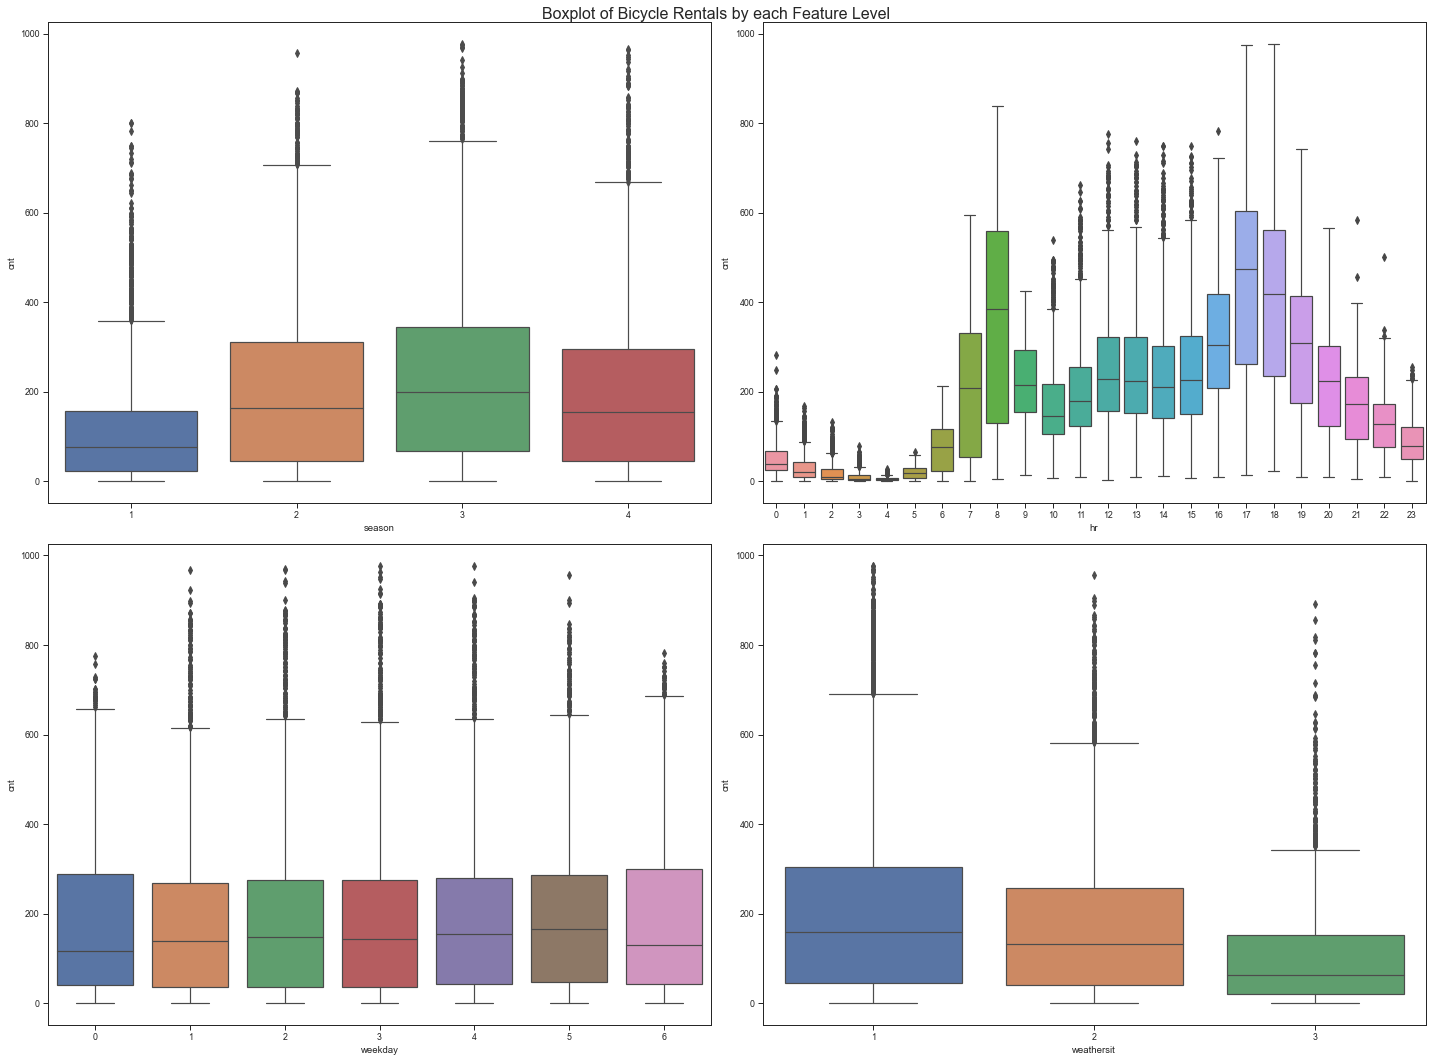

In [14]:
# Drop weekday from analysis
df = df.drop(columns = ['holiday', 'mnth'])

# Define Categorical Attributes
categorical_attrbs = ['season', 'hr', 'weekday', 'weathersit']

# Define Figure and Title
fig, ax = plt.subplots(2, 2, figsize = (20, 15))
fig.suptitle('Boxplot of Bicycle Rentals by each Feature Level',
             fontsize = 16)

# Plot Split-Box Plots
for attribute, subplot in zip(categorical_attrbs, ax.flatten()):
    sns.boxplot(x = df[attribute], y = df['cnt'], ax = subplot)

# Save Figure
save_fig('Split_Boxplots')

The following conclusions can be made about the number of bicycle rentals for this dataset:

 - They are higher in the warmer seasons than the colder seasons. 1 represents Winter which has the lowest median of bicycle rentals. 2 and 3 represent spring and summer respectively, where summer exhibits the highest average bike rentals of all seasons. 4 represents fall which has a lower average than spring and summer but higher than that of winter.
 - Rentals have a peak at 8 AM and 5 PM. There exists a consistent increase when approproaching these two values and a consistent decrease after, especially past 5 PM.
 - There is a higher average of bicycle rentals on the weekdays compared to the weekend.
 - If we interpret the numerical encoding of `weathersit` as 1 being the "nicest" weather and 3 being the "worst", there is a clear downward trend of the median rentals as the weather gets worse.

# 2.3 INTERACTIONS
Recall that interactions are when the predictive power of an attribute on the target is dependent on another variable. Consider the following:

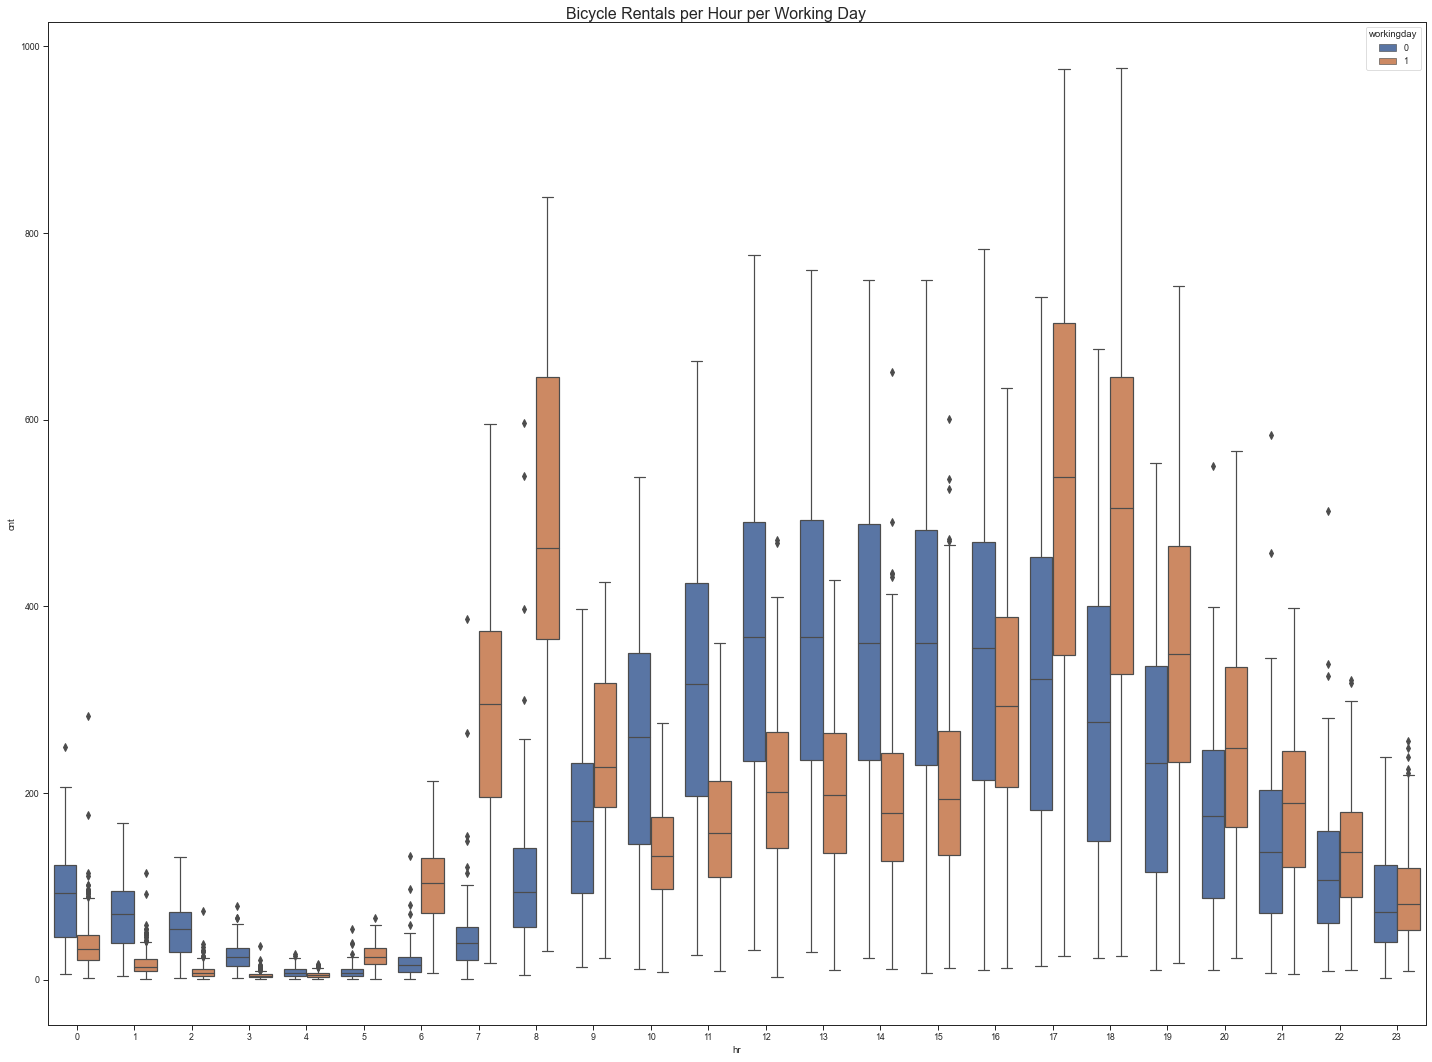

In [15]:
# Define Figure and Title
fig = plt.figure(figsize = (20,15))
fig.suptitle('Bicycle Rentals per Hour per Working Day',
             fontsize = 16)

# Plot Boxplot
sns.boxplot(x = df['hr'], y = df['cnt'],
            hue = df['workingday'])

# Save Figure
save_fig('Hr_Holiday_Interaction')

As shown in the split boxplots, the effect that `hr` has on `cnt` is very dependent on `workingday`. Bicycle rentals are much higher for non-working days from 12 AM - 4 AM and 10 AM - 4 PM. Conversely, rentals are much higher for working days from 5 AM - 9 AM and 5 PM onward. This makes intuitive sense, as 5 AM - 9 AM and 5 PM represents people's morning commute to work and evening commute home, respectively.

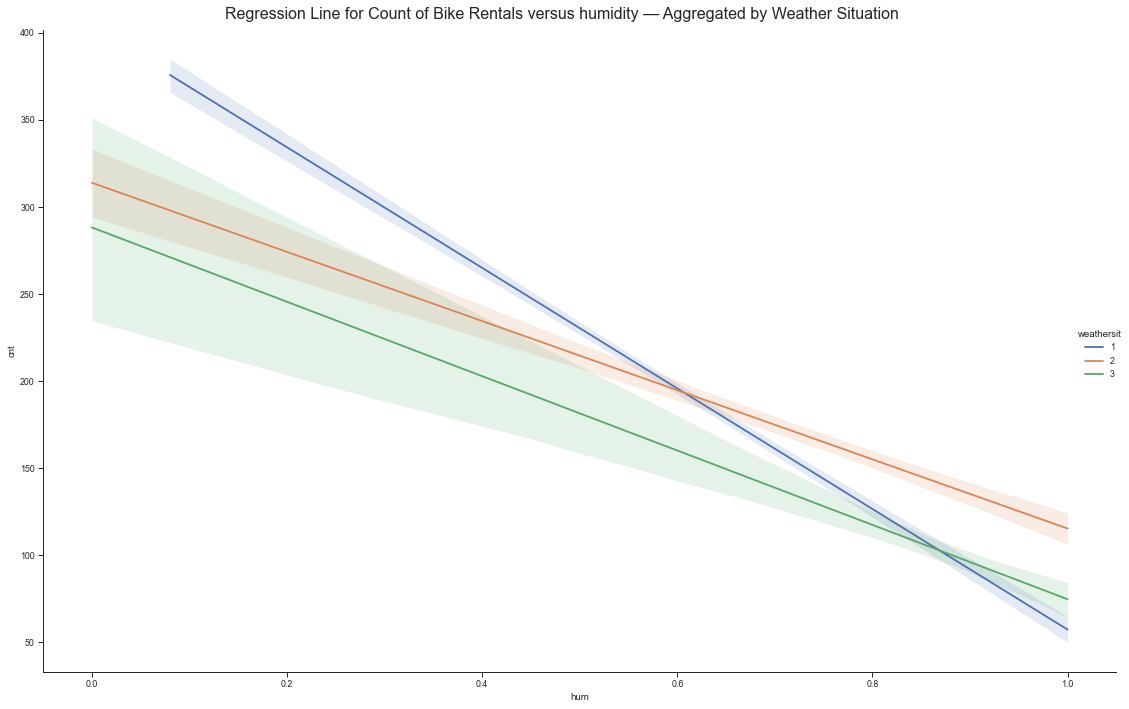

In [16]:
# Plot Regression Lines w/o Individual Points so that interaction is more clear
sns.lmplot(x = 'hum', y = 'cnt', hue = 'weathersit', data = df, scatter = False,
          height = 10,
          aspect = 1.5)

# Define Title
plt.suptitle('Regression Line for Count of Bike Rentals versus humidity — Aggregated by Weather Situation',
             fontsize = 16)

# Save Figure
save_fig('Humidity_Weathersit_Interaction')

The above graph plots the regression lines for `hum` and `cnt` aggregated by `weathersit`. Since the slopes of humidity within each group of `weathersit` are different, there is likely a statistically significant interaction between the two variables.

# 3. MODEL TRAINING
With the appropriate data manipulations in place, it is now time to train the models.

The goal of this section is to try different candidate models. Each will exhibit different levels of flexibility in an effort to achieve adequate performance while retaining interpretability. Since this is a regression problem, performance will be based on the RMSE on the train/test set. There will also be other metrics to take into consideration based on the model. An example includes using the $R^2$ metric to assess the performance between different linear regressions.

## 3.1 PREPROCESSING
An 80/20 split will be used for the training and testing sets. There will also be no column transformers defined for the following reasons:

  - There will be no need for one hot encoding.
    - The linear models will be built using the `statsmodel` framework since it provides a more "statistical output." `statsmodels` does not require categorical variables to be one hot encoded as it performs the binarization automatically. The non-parametric models will all be tree-based and one hot encoding is usually not advisable for these kind of algorithms.
    - The categorical variables were already numerically encoded. If the current encoding of the variables were to be remapped so that each one start at 0 it may make the interpretation for the coefficient estimates confusing. One workaround would be to map on the appropriate string values for each variable and then encode them, but this is saved for the Streamlit application where the string values will be mapped on after the user inputs the appropriate information.
  - There is no need for standardization since all of the numeric variables have been "standardized" already (they have actually been min-max scaled, but each attribute is defined between 0 and 1 so we leave as is).
  - The interaction terms do not need to be supplied in advance since `statsmodels` uses an R-like framework that easily incorporates interactions. Furthermore, the tree-based models extract interactions automatically if they exist.
  - Lastly, `cnt` does not need to be log-transformed beforehand.
    - `statsmodels` will allow `cnt` to be transformed by defining it in the model formula.
    - It is not necessary to transform `cnt` for the generalized linear model since a log-link with Poisson regression will be used.
    - Tree-based methods are invariant to these types of transformations.

As a check, it is always good practice to check the performance of the stratified sampling for the target variable.

In [17]:
# Split Attributes and Target
X = df.drop('cnt', axis = 1)
y = df[['cnt']]

# Create Splits
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size = 0.2, random_state = 42)

# Calculate Bicycle Count Averages for Train and Test Set
train_mean = y_train['cnt'].mean()
test_mean = y_test['cnt'].mean()

# Print to Screen
print('The average number of bicycles rented in the training set is approximately ' + str(int(train_mean)))
print('The average number of bicycles rented in the test set is approximately ' + str(int(test_mean)))

The average number of bicycles rented in the training set is approximately 190
The average number of bicycles rented in the test set is approximately 186


## 3.2 PARAMETRIC MODELS
This section will include the linear regression and the generalized linear model.

### 3.2.1 LINEAR REGRESSION
There will be three linear models under consideration:

  1. One that uses the entire dataset.
  2. One that incorporates the interactions.
  3. One that incorporates the log-transformation and interactions.

#### 3.2.1.1 LINEAR REGRESSION USING ORIGINAL DATASET
The dependent and independent variables will be brought back into a single dataframe so that modeling the interactions will be simpler.

In [18]:
# Combine X_train and y_train
train_full = X_train.copy()
train_full['cnt'] = y_train['cnt']

# Define Regression Formula
formula = 'cnt ~ season + hr + weekday + workingday + hum + weathersit + temp + windspeed'

# Train Model
lin_reg1 = smf.ols(formula = formula, data = train_full)
lin_reg1_results = lin_reg1.fit()

# Print Summary and RMSE
print(lin_reg1_results.summary())
lin_reg1_rmse = calculate_rmse(lin_reg1_results, X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     611.7
Date:                Fri, 15 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:37:14   Log-Likelihood:                -85265.
No. Observations:               13900   AIC:                         1.706e+05
Df Residuals:                   13861   BIC:                         1.709e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -26.3966      7.441     

The model is performing decently well for a baseline model. The adjusted $R^2$ is 0.625 which means that 62.5% of the variation of `cnt` is explained by the predictors. The model coefficients signal that all of the attributes are considered significant at the 0.05 level except for a few levels of the categorical variables. None of these levels are removed since it is bad practice to drop only certain levels of a categorical variable (dropping one level may cause high variance in the p-values of other levels). Finally, the $F$ statistic is large at 611.7 and the probability of the $F$-statistic is essentially zero, meaning that there exists some evidence that at least one of the attributes is an important predictor of bicycle rentals.

The last thing to note is the RMSE of the model, which is approximately 112.

#### 3.2.1.2 LINEAR REGRESSION USING INTERACTION TERMS

In [19]:
# Define Regression Formula
formula = 'cnt ~ season + hr * workingday + weekday + hum * weathersit + temp + windspeed'

# Train Model
lin_reg2 = smf.ols(formula = formula, data = train_full)
lin_reg2_results = lin_reg2.fit()

# Calculate RMSE
lin_reg2_rmse = mean_squared_error(y_train, lin_reg2_results.predict(X_train), squared = False)

# Print Summary and RMSE
print(lin_reg2_results.summary())
lin_reg2_rmse = calculate_rmse(lin_reg2_results, X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     693.5
Date:                Fri, 15 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:37:15   Log-Likelihood:                -82204.
No. Observations:               13900   AIC:                         1.645e+05
Df Residuals:                   13836   BIC:                         1.650e+05
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

By incorporating the synergy effect of the interactions the adjusted $R^2$ increased significantly to 75.8%! Note that the $F$ statistic also increased to 693.5 and that the $AIC$ and $BIC$ decreased a sizeable amount which gives evidence that this model is likely a better fit. The RMSE of this model is appoximately 90. A smaller RMSE is expected since the degrees of freedom increased from 38 to 63 (incorporating more terms in the regression increased the variance).

#### 3.2.1.3 LINEAR REGRESSION W/ INTERACTIONS AND LOG-TRANSFORMATION OF TARGET
The log-transformation is now incorporated to hopefully extract more predictive accuracy and increase the adjusted $R^2$. Recall that the log-transformation is being performed since:

 1. `cnt` is valid for integers greater than or equal to 1, and
 2. The severe right-skewness of `cnt` suggests that it would be better modeled using a log-transformation due to the normality assumptions.

In [20]:
# Define Regression Formula
formula = 'np.log(cnt) ~ season + hr * workingday + weekday + hum * weathersit + temp + windspeed'

# Train Model
lin_reg3 = smf.ols(formula = formula, data = train_full)
lin_reg3_results = lin_reg3.fit()

# Calculate RMSE
lin_reg3_rmse = mean_squared_error(y_train, np.exp(lin_reg3_results.predict(X_train)), squared = False) # Calculate separately due to exponentiation

# Print Summary and RMSE
print(lin_reg3_results.summary())
print(f'The RMSE of the model is: {lin_reg3_rmse}')

                            OLS Regression Results                            
Dep. Variable:            np.log(cnt)   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     2017.
Date:                Fri, 15 Apr 2022   Prob (F-statistic):               0.00
Time:                        10:37:15   Log-Likelihood:                -9110.5
No. Observations:               13900   AIC:                         1.835e+04
Df Residuals:                   13836   BIC:                         1.883e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

The log-transformation has pushed the adjusted $R^2$ to over 90%. The $F$ statistic also increased immensely to 2017 and the $AIC$ and $BIC$ also exhibit large decreases. Lastly, the RMSE decreased but only marginally. This may imply that while the predictiveness of the model has increased, a linear regression may not be the best fit for a log-transformed `cnt`. Recall that the purpose of the log-transformation was to help satisfy the normality assumption. Specifically, it was to help the residuals of the linear regression be normally distributed since this is what exemplifies a linear relationship between the attributes and target.

To diagnose the model fit, a Q-Q plot is constructed:

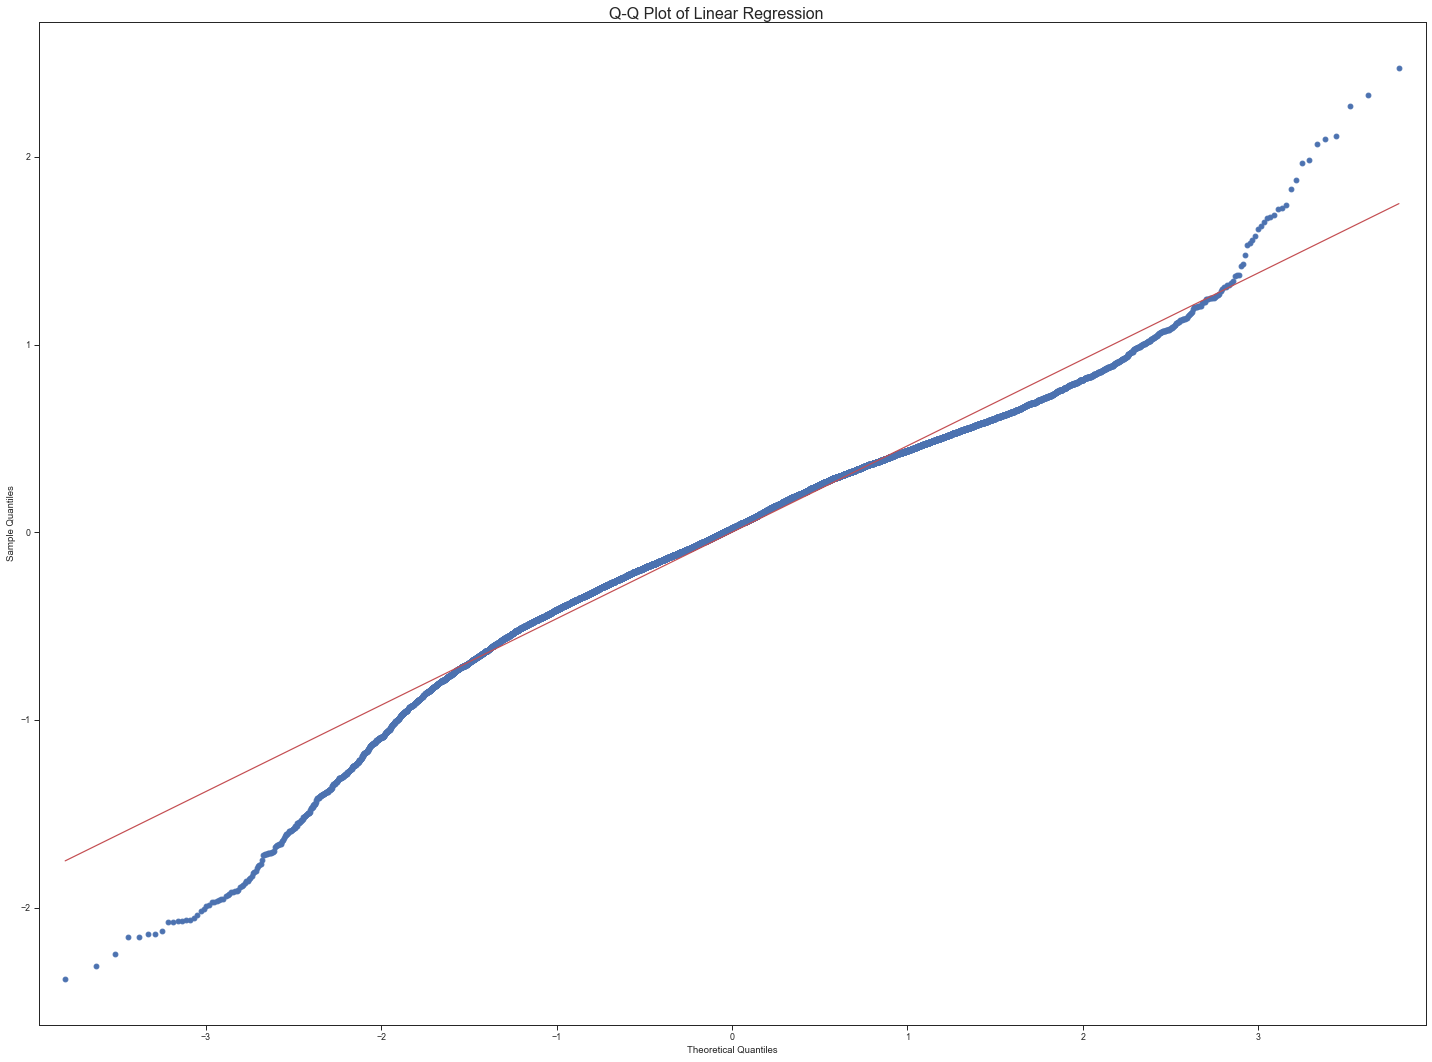

In [21]:
# Extract Residuals
resid = lin_reg3_results.resid

# Change Size of Figure
with mpl.rc_context():
    mpl.rc("figure", figsize = (20 ,15))
    graphics.gofplots.qqplot(resid, line = 'r')

# Define Title
plt.suptitle('Q-Q Plot of Linear Regression',
             fontsize = 16)
    
# Save Figure
save_fig('QQ_Plot_Linear_Regression')

The residuals deviate significantly from the fitted line at both ends. Based on the position of the residuals it seems that transforming `cnt` overadjusted the predictions in the model and are underfitting. This gives evidence that `cnt` is likely not linearly related to the attributes, regardless of transformation or not. In an attempt to better model the distribution of `cnt` without having the constraints of the linear model, a Poisson GLM with a log-link is used.

### 3.2.2 POISSON GLM W/ LOG-LINK AND INTERACTIONS
GLMs offer the benefit of not having the target variable connstrained by normality assumptions. It needs to only be a member of the exponential family of distributions. One such distribution is the discrete Poisson distribution. The Poisson is chosen since it is one of the most natural candidates for discrete non-negative integers. When constructing GLM models it is imperative to choose a link-function. This link-function linearly maps the target mean to the predictors. The log-link is chosen since it ensures that predictions are always positive (it is not possible to have negative bike rentals). Furthermore, the log-link also has the advantage of being easy to interpret becuase it generates a multiplicative model of coefficient estimates.

In [22]:
# Define Formula
formula = 'cnt ~ season + hr * workingday + weekday + hum * weathersit + temp + windspeed'

# Train Model
glm_reg = smf.glm(formula = formula, data = train_full, family = sm.families.Poisson()).fit()

# Print Summary and RMSE
print(glm_reg.summary())
glm_reg1_rmse = calculate_rmse(glm_reg, X_train, y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    cnt   No. Observations:                13900
Model:                            GLM   Df Residuals:                    13836
Model Family:                 Poisson   Df Model:                           63
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1114e+05
Date:                Fri, 15 Apr 2022   Deviance:                   3.3356e+05
Time:                        10:37:17   Pearson chi2:                 3.36e+05
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

The RMSE is lower than any of the linear regressions. However, it needs to be determined if the model is a good fit for the data. Unlike linear regressions, traditional goodness-of-fit measures which are based in part of the normal distribution (like $R^2$) do not apply. For GLMs it is often the case to diagnose the fit using the deviance of the model. These deviance residuals are similar to the raw residuals of a linear model in that they should also be approximately normally distributed.

A Q-Q plot is again used to assess the fit.

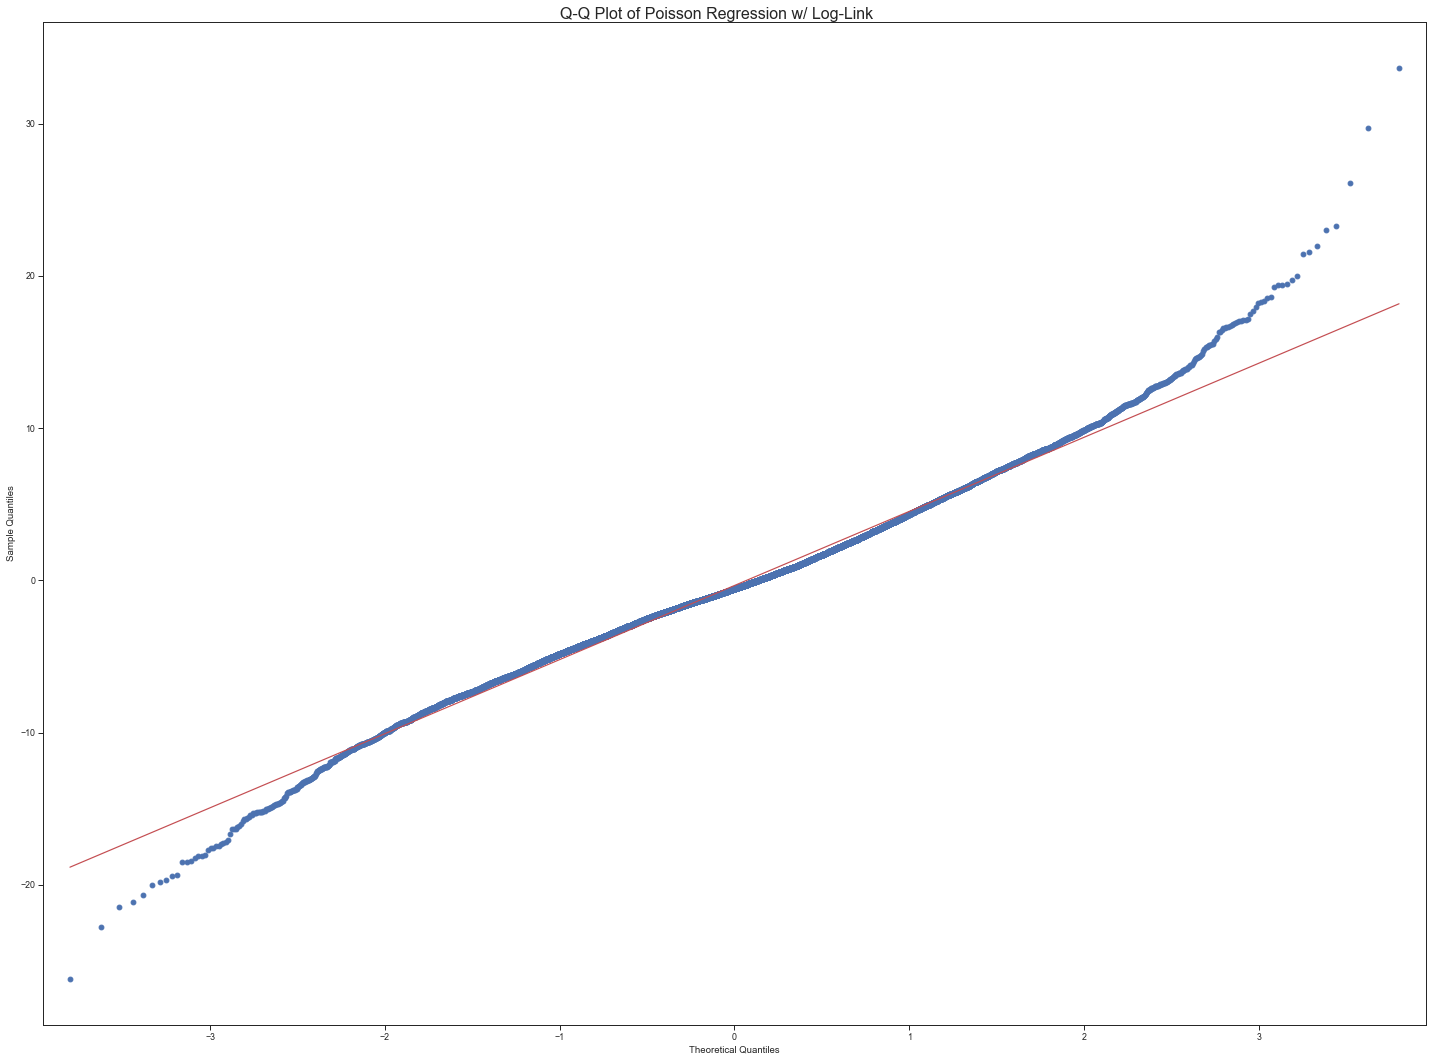

In [23]:
# Extract Deviance Residuals
resid = glm_reg.resid_deviance.copy()

# Change Size of Figure
with mpl.rc_context():
    mpl.rc("figure", figsize=(20 ,15))
    graphics.gofplots.qqplot(resid, line='r')

# Define Title
plt.suptitle('Q-Q Plot of Poisson Regression w/ Log-Link',
             fontsize = 16)
    
# Save Figure
save_fig('QQ_Plot_Poisson_Regression')

Unlike the log-transformed linear regression, the residuals of the GLM scatter much more closely along the fitted line. But they are similar in that the deviance residuals deviate from the fitted line at the tail-ends of the distribution. This implies that there are a lot more large (small) deviance residuals than would be anticipated under the Poisson distribution. To put more simply, the distribution of `cnt` is much more skewed than the Poisson distribution that has been supplied.

All in all, the Poisson regression is a better fit for `cnt` than the standard linear regression based on the differences in the Q-Q plot, but evidence suggests that a more powerful / flexible model will likely be of better use (at least in terms of predictibility). Non-parametric methods (specifically tree methods) are now considered.

Before moving on, it is important to note that regularization will not be incorporated since:
  - The coefficient estimates are small, so shrinking them closer to 0 will likely not benefit, and
  - nearly all predictors are significant, so feature selection is not a priority.

## 3.3 NON-PARAMETRIC MODELS
Since overfitting is much more of an issue for non-parametric models, the RMSE will be averaged over 5 folds using cross-validation instead of just calculating it based on the training set with no adjustments.

### 3.3.1 DECISION TREES

Decision trees are desirable in this situation for the following reasons:

 - There is evidence that the count of bicycles may not be best represented by a linear relationship. Decision trees excel in handling nonlinear relationships since they divide the predictor space into regions where the effect of the attributes on the target differ substantially.
 - Decision trees can take care of skewed variables without the need for variable transformations, so manually altering `cnt` is not needed.
 - Interactions are automatically accomdated.

#### 3.3.1.1 BASE DECISION TREE

In [24]:
#Instantiate Model
tree_reg = DecisionTreeRegressor(random_state = 42)

#Train Model
tree_reg.fit(X_train, y_train)

#Calculate RMSE and Print to Screen
tree_reg_rmse = calculate_rmse_cv(tree_reg, X_train, y_train)

The average RMSE score is : 95.55


The RMSE implies that the decision tree does not outperform either of the best linear models. Recall that the RMSE is averaged over 5-folds instead of the entire training set so the comparison is somewhat apples-to-oranges. Unfortunately, `statsmodels` does not currently support functionality for Scikit-Learn's `cross_val_score()` function. Since it is a linear model, however, it is safe to assume that there does not exist much variance in the prediction values.

Hyperparameter tuning could be done to increase the accuracy, but a random forest model is considered over a tuned decision tree since the ensemble nature of the random forest (pun totally intended) usually leads to better performance. Before doing so, the number of nodes in the decision tree is calculated to get a sense of its size and what predictors it deemed most influential for the model.

In [25]:
# Calculate Nodes
calculate_nodes(tree_reg)

There are 26637 nodes in the regression tree.


With over 26,600 nodes it is not advisable to try and visualize the entire tree, but a subset of the tree can be viewed to show some of the more influential predictors.

In [26]:
print(export_text(tree_reg, feature_names = X_train.columns.to_list(), max_depth = 5))

|--- hr <= 6.50
|   |--- hr <= 5.50
|   |   |--- hr <= 1.50
|   |   |   |--- workingday <= 0.50
|   |   |   |   |--- temp <= 0.49
|   |   |   |   |   |--- season <= 2.50
|   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |--- season >  2.50
|   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |--- temp >  0.49
|   |   |   |   |   |--- hr <= 0.50
|   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |--- hr >  0.50
|   |   |   |   |   |   |--- truncated branch of depth 14
|   |   |   |--- workingday >  0.50
|   |   |   |   |--- hr <= 0.50
|   |   |   |   |   |--- temp <= 0.43
|   |   |   |   |   |   |--- truncated branch of depth 17
|   |   |   |   |   |--- temp >  0.43
|   |   |   |   |   |   |--- truncated branch of depth 16
|   |   |   |   |--- hr >  0.50
|   |   |   |   |   |--- temp <= 0.45
|   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |--- temp >  0.45
|   |   |   |   |   |   |-

It appears that `hr` is overwhelmingly the most important variable due to the fact that it seems to be used to split the tree more early and more frequently. Another way of contexualizing this is that `hr` generally leads to larger improvements in the node purity relative to the other variables. `temp`, `workingday`, and `season` also appear to be influential predictors.

### 3.3.2 RANDOM FOREST

Recall that random forests are a type of ensemble method. Instead of relying on the results of a single tree, random forests will utilize multiple base models that are averaged together.

Before implementation, it is important to note that random forests are inferior to decision trees in that they are much less interpretable since hundreds of decision trees may be utilized. However, since the decision tree built before has large depth, the interpretibility downfall becomes pretty negligible.

#### 3.3.2.1 BASE RANDOM FOREST

We begin by building a random forest regression with default hyperparameters.

In [27]:
# Instantiate Random Forest
rf_reg1 = RandomForestRegressor(random_state = 42)

# Train Model
rf_reg1.fit(X_train, y_train.values.ravel())

# Calculate RMSE and Print to Screen
rf_reg1_rmse = calculate_rmse_cv(rf_reg1, X_train, y_train.values.ravel())

The average RMSE score is : 70.43


The random forest has achieved the best RMSE score so far. Since this model seems promising a randomzied grid-search is performed in hopes to further increase its performance. The randomized grid is used in favor of a normal grid search due to computation time.

In [28]:
# Define Grid
rf_random_grid = {'n_estimators': [50, 100, 500, 1000, 2000],
               'max_features': ['auto', 'sqrt', 'log2'],
               'max_depth': [None, 10, 30, 60, 90],
               'min_samples_split': [2, 5, 10, 15],
               'min_samples_leaf': [1, 5, 10, 15]
              }

# Instantiate Grid
rf_reg_random = RandomizedSearchCV(estimator = rf_reg1,
                                   param_distributions = rf_random_grid,
                                   cv = 5,
                                   random_state = 42,
                                   scoring = 'neg_root_mean_squared_error',
                                   n_jobs = -1)
# Perform Search
rf_reg_random.fit(X_train, y_train.values.ravel())

# Print Best Parameters
rf_reg_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 90}

The fit is performed using the best parameters from the randomized search.

In [29]:
# Copy Best Parameters from Randomized Search
rf_reg2 = rf_reg_random.best_estimator_

# Train Model
rf_reg2.fit(X_train, y_train.values.ravel())

# Calulcate RMSE and Print to Screen
rf_reg2_rmse = calculate_rmse_cv(rf_reg2, X_train, y_train.values.ravel())

The average RMSE score is : 69.30


The RMSE decreased but only marginally. Using a normal grid search or increasing the number of iterations for the randomized search may produce a more robust model but given that this is the best model so far, we move forward with it.

Since random forests cannot be easily visualized, the feature importances are graphed instead. How "important" a feature is in this model can be similarly interpreted to how important features were contexualized in the decision trees in that an important feature is one that exhibits the greatest decreases in node impurity. The difference here is that each variable is represented with an "importance score."

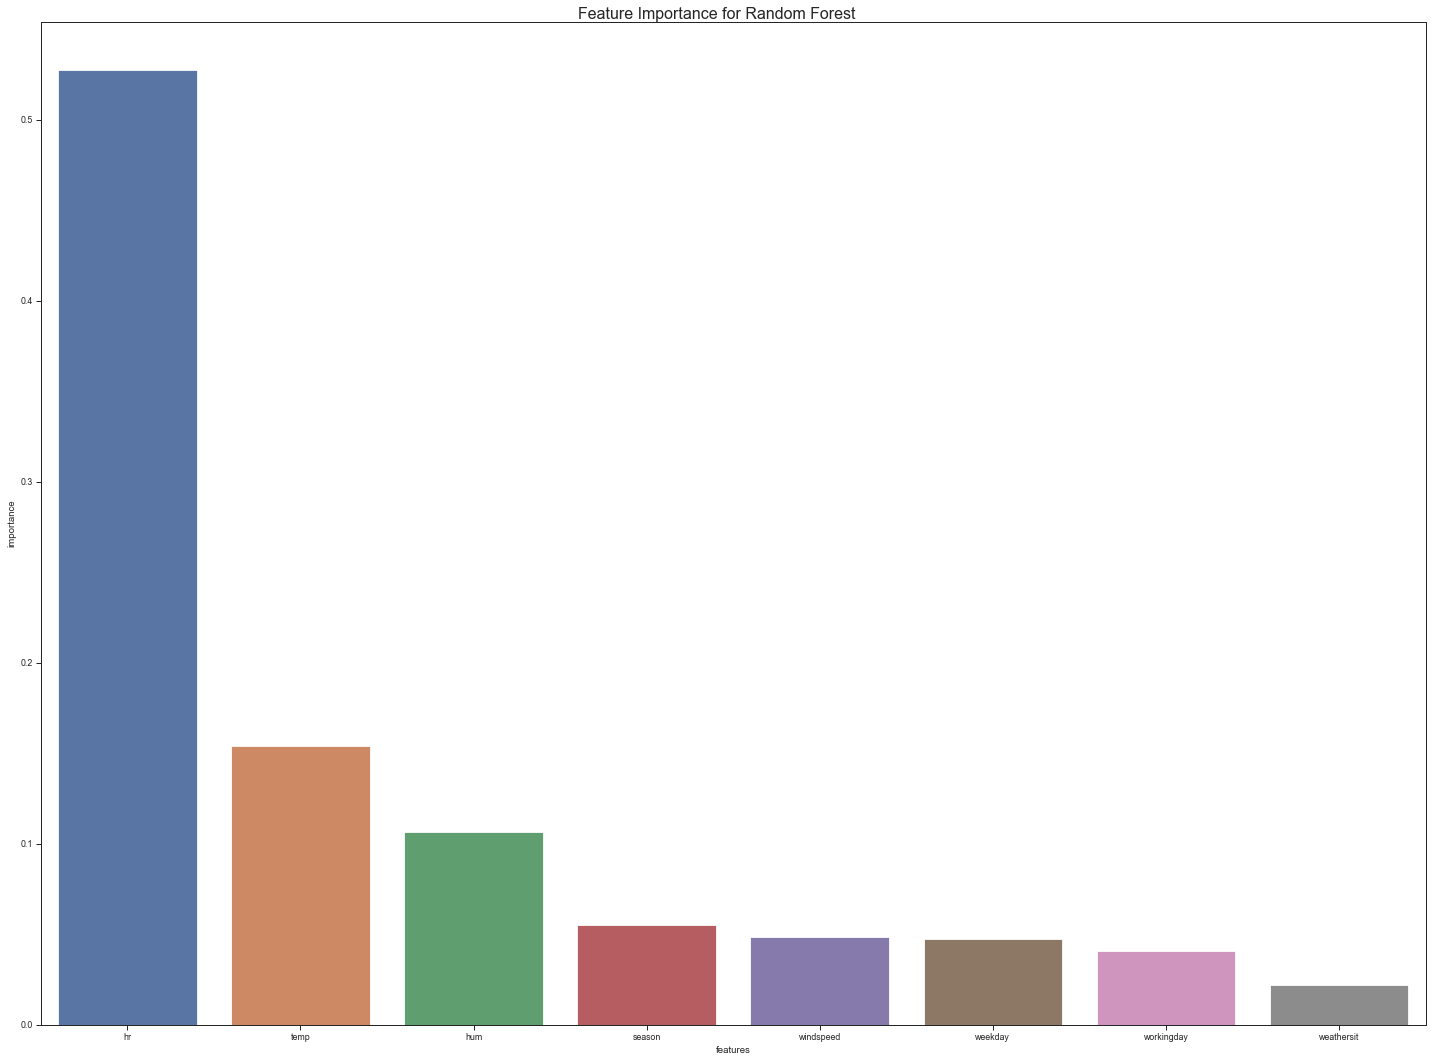

In [30]:
calculate_feature_imp(rf_reg2, X_train, 'Feature Importance for Random Forest', 'Feature_Importance_Random_Forest')

The feature importance scores imply that most of the important features for the random forest are similar to the important features for the decision tree with the exception of `hum` which did not appear as important among the other predictors.

### 3.3.3 GRADIENT BOOSTED TREE

The final model will be a Gradient Boosted Tree. Boosted trees often perform better in terms of prediction accuracy due to their emphasis on bias reduction (recall that the framework for boosted trees is sequentially fitting trees to the residuals of the previous tree), but these models are also more vulnerable to overfitting.

#### 3.3.3.1 BASE GRADIENT BOOSTED TREE

In [31]:
# Instantiate GradientBoostingRegressor
xgb_reg1 = GradientBoostingRegressor(random_state = 42)

# Train Model
xgb_reg1.fit(X_train, y_train.values.ravel())

# Calculate RMSE and Print to Screen
xgb_reg1_rmse = calculate_rmse_cv(xgb_reg1, X_train, y_train.values.ravel())

The average RMSE score is : 85.54


The gradient-boosted model does not outperform the Poisson regression. It is likely that the model is underfitting the data since the other ensemble method proved to be a better fit than the other models. A randomized search is used again to try and make the model more predictive.

#### 3.3.3.2 GRADIENT BOOSTED TREE W/ RANDOMIZED SEARCH

In [32]:
# Define Grid
xgb_random_grid = {'n_estimators':[100, 500, 1000, 1500],
                   'learning_rate': [0.01, 0.1, 0.05, 0.02],
                   'max_depth':[4, 7, 10],
                   'min_samples_leaf':[3, 5, 9, 17],
                   'max_features':[0.1, 0.3, 1.0]}

# Instantiate Grid
xgb_reg_random = RandomizedSearchCV(estimator = xgb_reg1,
                                   param_distributions = xgb_random_grid,
                                   cv = 5,
                                   random_state = 42,
                                   scoring = 'neg_root_mean_squared_error',
                                   n_jobs = -1)

# Perform the Search
xgb_reg_random.fit(X_train, y_train.values.ravel())

# Print best values
xgb_reg_random.best_params_

{'n_estimators': 1000,
 'min_samples_leaf': 5,
 'max_features': 0.3,
 'max_depth': 10,
 'learning_rate': 0.01}

The model is now rebuilt using the optimal parameters from the search.

In [33]:
# Extract Best Parameters from Randomized Search
xgb_reg2 = xgb_reg_random.best_estimator_

# Train Model
xgb_reg2.fit(X_train, y_train.values.ravel())

# Calculate RMSE and Print to Screen
xgb_reg2_rmse = calculate_rmse(xgb_reg2, X_train, y_train)

The RMSE of the model is: 39.22


This model is the best out of all models from an accuracy standpoint. Unfortunately, this large increase in performance may mean that the model is overfitting. Using the model to predict the test set will ultimately determine if this is true. Nonetheless, we move forward with this fit.

Similar to earlier, the feature importances are plotted.

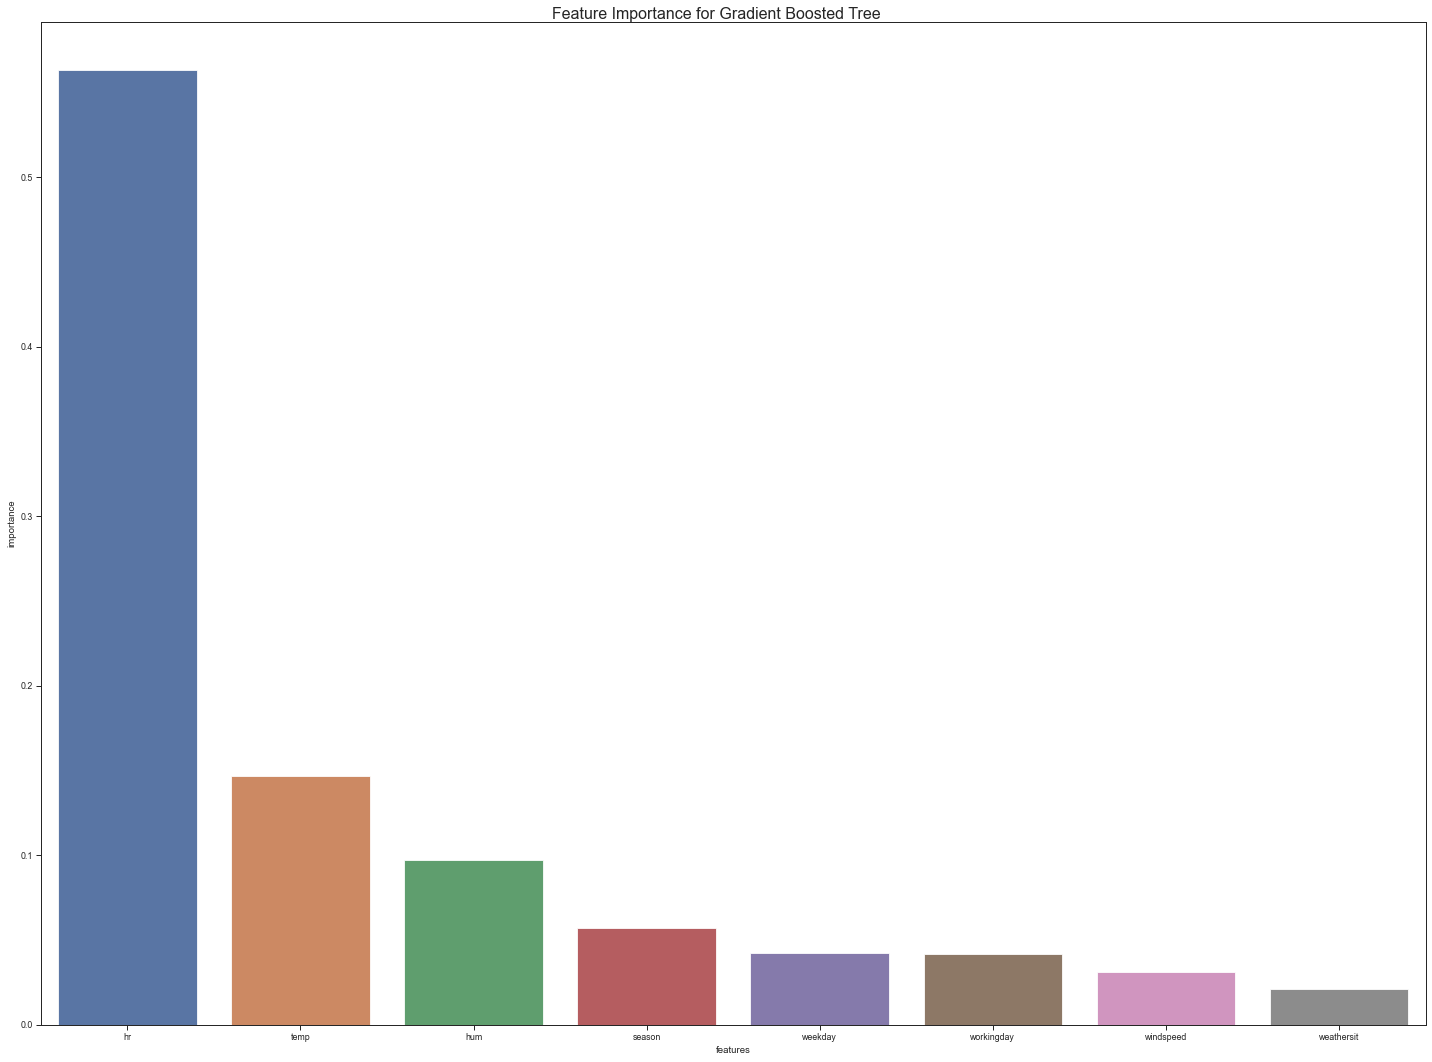

In [34]:
calculate_feature_imp(xgb_reg2, X_train, 'Feature Importance for Gradient Boosted Tree', 'Feature_Importance_Gradient_Boosted_Tree')

The variable importance plot is nearly identical to that of the Random Forest. For all three tree based methods `hr`, `temp` and `season` have been the most influential attributes.

## 3.4 SUMMARY OF MODEL PERFORMANCE ON THE TRAINING SET
Before determining the model performance on the test set, a summary of the RMSE based on the training data is provided:

In [35]:
# Instantiate Table
train_rmse = PrettyTable()

# Add Fields
train_rmse.field_names = ['Model', 'Training RMSE']
train_rmse.add_rows(
    [
        ['Linear Regression w/ Log-Transformation & Interactions', '{0:.4f}'.format(lin_reg3_rmse)],
        ['Poisson Regression w/ Log-Link & Interactions', '{0:.4f}'.format(glm_reg1_rmse)],
        ['Base Decision Tree', '{0:.4f}'.format(tree_reg_rmse)],
        ['Random Forest w/ Randomized Hyperparameter Tuning', '{0:.4f}'.format(rf_reg2_rmse)],
        ['Gradient Boosted Tree w/ Randomized Hyperparameter Tuning', '{0:.4f}'.format(xgb_reg2_rmse)]
    ]
)

print(train_rmse)

+-----------------------------------------------------------+---------------+
|                           Model                           | Training RMSE |
+-----------------------------------------------------------+---------------+
|   Linear Regression w/ Log-Transformation & Interactions  |    88.5667    |
|       Poisson Regression w/ Log-Link & Interactions       |    81.6309    |
|                     Base Decision Tree                    |    95.5451    |
|     Random Forest w/ Randomized Hyperparameter Tuning     |    69.2991    |
| Gradient Boosted Tree w/ Randomized Hyperparameter Tuning |    39.2181    |
+-----------------------------------------------------------+---------------+


# 4. MODEL VALIDATION ON TEST SET

In [36]:
### Calculate Test RMSE's
# Calculate RMSE
lin_reg_test_rmse = mean_squared_error(y_test, np.exp(lin_reg3_results.predict(X_test)), squared = False) # Done separately due to exponentiation

# Poisson Regression
glm_reg_test_rmse = calculate_rmse_test(glm_reg)

# DT
tree_reg_test_rmse = calculate_rmse_test(tree_reg)

# RF
rf_reg_test_rmse = calculate_rmse_test(rf_reg2)

# GB
xgb_reg_test_rmse = calculate_rmse_test(xgb_reg2)

# Instantiate Table
test_rmse = PrettyTable()

# Add Fields
test_rmse.field_names = ['Model', 'Test RMSE']
test_rmse.add_rows(
    [
        ['Linear Regression w/ Log-Transformation & Interactions', '{0:.4f}'.format(lin_reg_test_rmse)],
        ['Poisson Regression w/ Log-Link & Interactions', '{0:.4f}'.format(glm_reg_test_rmse)],
        ['Decision Tree w/ Cost-Complexity Pruning', '{0:.4f}'.format(tree_reg_test_rmse)],
        ['Random Forest w/ Randomized Hyperparameter Tuning', '{0:.4f}'.format(rf_reg_test_rmse)],
        ['Gradient Boosted Tree w/ Randomized Hyperparameter Tuning', '{0:.4f}'.format(xgb_reg_test_rmse)]
    ]
)

print(test_rmse)

+-----------------------------------------------------------+-----------+
|                           Model                           | Test RMSE |
+-----------------------------------------------------------+-----------+
|   Linear Regression w/ Log-Transformation & Interactions  |  91.5580  |
|       Poisson Regression w/ Log-Link & Interactions       |  82.8643  |
|          Decision Tree w/ Cost-Complexity Pruning         |  92.6805  |
|     Random Forest w/ Randomized Hyperparameter Tuning     |  64.7621  |
| Gradient Boosted Tree w/ Randomized Hyperparameter Tuning |  60.8703  |
+-----------------------------------------------------------+-----------+


The comparison of each model in relation to the test RMSE is very similar to that of the model comparisons using the train RMSE. To no surpise the ensemble methods performed the best on the test set but it appears that the gradient boosted tree was infact overfitting. To better illustrate this, consider the following:

In [37]:
# Calculate Percentage Increase
lin_reg_comp = (lin_reg_test_rmse / lin_reg3_rmse) - 1
glm_reg_comp = (glm_reg_test_rmse / glm_reg1_rmse) - 1
tree_reg_comp = (tree_reg_test_rmse / tree_reg_rmse) - 1
rf_reg_comp = (rf_reg_test_rmse / rf_reg2_rmse) - 1
xgb_reg_comp = (xgb_reg_test_rmse / xgb_reg2_rmse) - 1

# Instatiate Table
comparisons = PrettyTable()

# Add Fields
comparisons.field_names = ['Model', 'Percent Increase from Train to Test RMSE']
comparisons.add_rows(
    [
        ['Linear Regression w/ Log-Transformation & Interactions', '{:.2%}'.format(lin_reg_comp)],
        ['Poisson Regression w/ Log-Link & Interactions', '{:.2%}'.format(glm_reg_comp)],
        ['Decision Tree w/ Cost-Complexity Pruning', '{:.2%}'.format(tree_reg_comp)],
        ['Random Forest w/ Randomized Hyperparameter Tuning', '{:.2%}'.format(rf_reg_comp)],
        ['Gradient Boosted Tree w/ Randomized Hyperparameter Tuning', '{:.2%}'.format(xgb_reg_comp)]
    ]
)

print(comparisons)

+-----------------------------------------------------------+------------------------------------------+
|                           Model                           | Percent Increase from Train to Test RMSE |
+-----------------------------------------------------------+------------------------------------------+
|   Linear Regression w/ Log-Transformation & Interactions  |                  3.38%                   |
|       Poisson Regression w/ Log-Link & Interactions       |                  1.51%                   |
|          Decision Tree w/ Cost-Complexity Pruning         |                  -3.00%                  |
|     Random Forest w/ Randomized Hyperparameter Tuning     |                  -6.55%                  |
| Gradient Boosted Tree w/ Randomized Hyperparameter Tuning |                  55.21%                  |
+-----------------------------------------------------------+------------------------------------------+


This clearly shows that the gradient boosted tree has overfit to the data. One surprising result is that the decision tree actually performed better on the test set than it did on the train set. The same is true for the random forest but normally decision trees are more susceptible to small changes in the dataset.

All in all, given that the random forest had the best RMSE on unseen data and that it is likely a robust model based on its reduction in variance, it will be chosen as the final model to go into production. An argument can be made that if interpretibility were the main objective than the Poisson regression would likely be the model chosen given its high bias and the fact that it is within 20 units of the random forest's RMSE.